In [1]:
import torch
import kornia
import cv2
import matplotlib.pyplot as plt 

from kornia.morphology import dilation, opening, closing
from kornia.utils import tensor_to_image, draw_rectangle
from kornia.contrib import connected_components
from kornia.geometry.transform import resize


In [113]:
def tensor_to_features(tensor, general_thresh=160, sidelength_threshold=50):

    assert tensor.ndim == 2
    
    # compute thresholded image (only white parts)
    thresholded = tensor[20:] > general_thresh

    # dilate to keep them together
    dilated = dilation(thresholded[None, None, :, :], torch.ones(5,20, device='cuda:0'), border_type='constant')
    connected_comp = connected_components(dilated, num_iterations=200)
    
    # keep connected components with large enough horizontal length
    labels = connected_comp.unique(sorted=True)[1:]
    kept_labels = []

    for lab in labels:
        _,_,x,y = torch.nonzero(torch.where(connected_comp == lab, 1, 0), as_tuple=True)

        if torch.max(y) - torch.min(y) > sidelength_threshold:
            kept_labels.append(lab)
            
    side = (connected_comp[..., None] == torch.tensor(kept_labels, device='cuda:0')).any(-1).double()

    # dilate side line to remove it from rest of image
    dilated_side = dilation(side, torch.ones(10,7,device='cuda:0'), border_type='constant')
    removed_upper = (thresholded.double() - dilated_side) > 0

    # close midline together
    closed_midline = closing(removed_upper, torch.ones(20,20, device='cuda:0'), border_type='geodesic')
    closed_midline = draw_rectangle(closed_midline, torch.tensor([[[0, 0, 160, 120]]], device='cuda:0'), fill=torch.zeros(1))

    # reassemble together in a single image
    resized_img = (resize(closed_midline + side,(16,16), interpolation='area') > 0.2).int()
    
    return resized_img

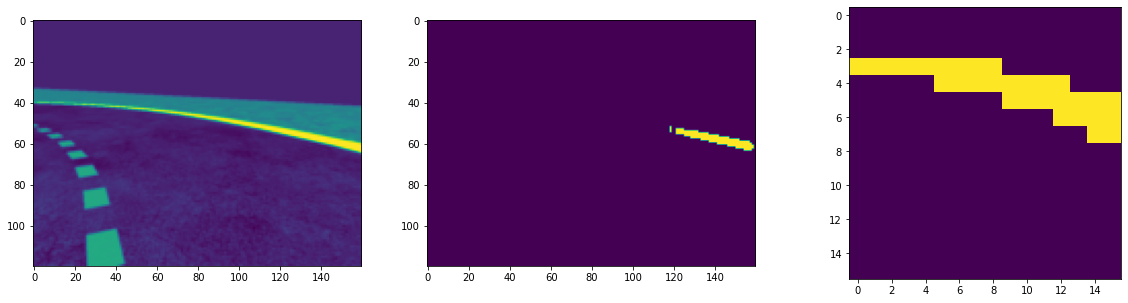

In [221]:
from kornia.filters import gaussian_blur2d, box_blur, median_blur

img = cv2.imread('data/left_0180.png', cv2.IMREAD_GRAYSCALE)
tensor = torch.tensor(img, device='cuda:0')

blurred = median_blur(tensor[None, None, :, :].double(), (7,7))

fig, axs = plt.subplots(ncols=3, figsize=(20,5))

axs[0].imshow(np.squeeze(tensor_to_image((tensor))))
axs[1].imshow(np.squeeze(tensor_to_image((blurred > 180))))

axs[2].imshow(np.squeeze(tensor_to_image(tensor_to_features(tensor, general_thresh=200))))

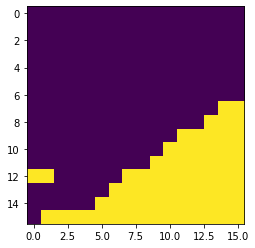

In [136]:
plt.imshow(np.squeeze(tensor_to_image(tensor_to_features(blurred[0,0]))))